In [1]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import sem
import itertools
from pprint import pprint

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

#load the data into dataframes
mouse_drug_data = pd.read_csv("data/mouse_drug_data.csv")
clinical_trial_data = pd.read_csv("data/clinicaltrial_data.csv")

# Combine the data into a single dataset
df_orig = pd.merge(mouse_drug_data,clinical_trial_data, on='Mouse ID')

df_orig.head()

,Mouse ID,Drug,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,f234,Stelasyn,0,45.000000,0
1,f234,Stelasyn,5,47.313491,0
2,f234,Stelasyn,10,47.904324,0
3,f234,Stelasyn,15,48.735197,1
4,f234,Stelasyn,20,51.112713,2


In [2]:
#Set the list of drugs we're interested in analyzing here. The full list of unique drugs is stored below for convenience
#if everything is working properly this is the only place you should have to hard code in drug names #robustitude
#I included "Ramicane" in the analysis since it also seems like a promising drug based on tumor response
#Feel free to choose others from the list below

druglist = ["Capomulin", "Infubinol", "Ketapril", "Ramicane", "Placebo"]

days = df_orig['Timepoint'].unique()
#druglist = df_orig['Drug'].unique()
#['Stelasyn', 'Propriva', 'Naftisol', 'Ketapril', 'Capomulin',
       #'Infubinol', 'Ceftamin', 'Zoniferol', 'Ramicane', 'Placebo']

# Tumor Response to Treatment
### I repeated this fundamental process several times throughout the homework to generate drugdf-drugdf4 so you'll see the commenting here, and then this method recycled later with sparse commenting


In [3]:
#make an empty dataframe to hold data
drugdf = pd.DataFrame([])

#loop through the data looking for data on one drug at a time from our list,groupby timepoint, add drugname just in case
#resulting dataframe has tumor volume, metastatic sites, and drugname as columns for each timepoint
for i in range(0,len(druglist)):
    #match drug
    temp1 = df_orig.loc[(df_orig['Drug'] == druglist[i])]
    #average across each timepoint for that drug
    temp2 = temp1.groupby('Timepoint').mean()
    #append drugname to column name so that we don't have redundant columns when we merge all the results into one DF
    temp2.rename(columns={"Tumor Volume (mm3)":str("Tumor Volume (mm3)_"+ druglist[i]),
                          "Metastatic Sites": str("Metastatic Sites_" + druglist[i])}, inplace = True)
    #on each pass other than the first pass we can merge on "Timepoint"
    if i != 0:
        drugdf = drugdf.merge(temp2, on = "Timepoint", how = 'outer')
    #on the first pass we can't merge since there was nothing in drugdf to begin with
    elif i == 0:
        drugdf = temp2    

In [4]:
#show the data or not, your choice!
drugdf

,Tumor Volume (mm3)_Capomulin,Metastatic Sites_Capomulin,Tumor Volume (mm3)_Infubinol,Metastatic Sites_Infubinol,Tumor Volume (mm3)_Ketapril,Metastatic Sites_Ketapril,Tumor Volume (mm3)_Ramicane,Metastatic Sites_Ramicane,Tumor Volume (mm3)_Placebo,Metastatic Sites_Placebo
Timepoint,,,,,,,,,,
0,45.000000,0.000000,45.000000,0.000000,45.000000,0.000000,45.000000,0.000000,45.000000,0.000000
5,44.266086,0.160000,47.062001,0.280000,47.389175,0.304348,43.944859,0.120000,47.125589,0.375000
10,43.084291,0.320000,49.403909,0.666667,49.582269,0.590909,42.531957,0.250000,49.423329,0.833333
15,42.064317,0.375000,51.296397,0.904762,52.399974,0.842105,41.495061,0.333333,51.359742,1.250000
20,40.716325,0.652174,53.197691,1.050000,54.920935,1.210526,40.238325,0.347826,54.364417,1.526316
25,39.939528,0.818182,55.715252,1.277778,57.678982,1.631579,38.974300,0.652174,57.482574,1.941176
30,38.769339,1.090909,58.299397,1.588235,60.994507,2.055556,38.703137,0.782609,59.809063,2.266667
35,37.816839,1.181818,60.742461,1.666667,63.371686,2.294118,37.451996,0.952381,62.420615,2.642857
40,36.958001,1.380952,63.162824,2.100000,66.068580,2.733333,36.574081,1.100000,65.052675,3.166667


# Store the Standard Error of Tumor Volumes Grouped by Drug and Timepoint

### I went ahead and stored the standard error of tumor volumes AND metastatic site count in drugdf2 in this step rather than breaking these out into two separate operations

In [5]:
#create an empty dataframe to hold standard errors grouped by timepoint
#create an empty dataframe to hold temporary values while looping
#basically the same loop as above except match on drug and timepoint the calculate SEM for all mice on that drug at that time
drugdf2 = pd.DataFrame([])
temp2 = pd.DataFrame([])

for i in range(0,len(druglist)):
    for j in range(0,len(days)):
        temp1 = df_orig.loc[(df_orig['Drug'] == druglist[i]) & (df_orig['Timepoint'] == days[j])]
        TumorSEM = sem(temp1["Tumor Volume (mm3)"])
        MetaSEM = sem(temp1["Metastatic Sites"])
        
        #set up a new dataframe for each new drug
        if j == 0:
            temp2 = pd.DataFrame(columns=["Timepoint",str("TumorVolumeSEM_" + druglist[i]),
                                          str("MetastaticSites_SEM_" + druglist[i])])
        temp2.loc[j] = [days[j],TumorSEM,MetaSEM]
        
    if i != 0:
        drugdf2 = drugdf2.merge(temp2, on = "Timepoint", how = 'outer')
    elif i == 0:
        drugdf2 = temp2

In [6]:
drugdf2

,Timepoint,TumorVolumeSEM_Capomulin,MetastaticSites_SEM_Capomulin,TumorVolumeSEM_Infubinol,MetastaticSites_SEM_Infubinol,TumorVolumeSEM_Ketapril,MetastaticSites_SEM_Ketapril,TumorVolumeSEM_Ramicane,MetastaticSites_SEM_Ramicane,TumorVolumeSEM_Placebo,MetastaticSites_SEM_Placebo
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5.0,0.448593,0.074833,0.235102,0.091652,0.264819,0.098100,0.482955,0.066332,0.218091,0.100947
2,10.0,0.702684,0.125433,0.282346,0.159364,0.357421,0.142018,0.720225,0.090289,0.402064,0.115261
3,15.0,0.838617,0.132048,0.357705,0.194015,0.580268,0.191381,0.770432,0.115261,0.614461,0.190221
4,20.0,0.909731,0.161621,0.476210,0.234801,0.726484,0.236680,0.786199,0.119430,0.839609,0.234064
5,25.0,0.881642,0.181818,0.550315,0.265753,0.755413,0.288275,0.746991,0.119430,1.034872,0.263888
6,30.0,0.934460,0.172944,0.631061,0.227823,0.934121,0.347467,0.864906,0.139968,1.218231,0.300264
7,35.0,1.052241,0.169496,0.984155,0.224733,1.127867,0.361418,0.967433,0.145997,1.287481,0.341412
8,40.0,1.223608,0.175610,1.055220,0.314466,1.158449,0.315725,1.128445,0.160591,1.370634,0.297294
9,45.0,1.223977,0.202591,1.144427,0.309320,1.453186,0.278722,1.226805,0.190221,1.351726,0.304240


# Plot Tumor Response vs. Time by Drug Type with Error Bars
## Tumor volumes come from drugdf in even # columns beginning with 0
## Standard errors for tumor volume come from drugdf2 in odd # columns beginning with 1

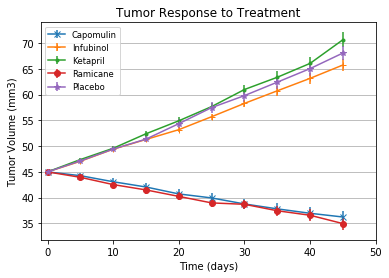

In [7]:
#make the plot
#set up a list of markers types to cycle through instead of hardcoding marker types by drugtype
marker = itertools.cycle(('x', '+', '.', 'o', '*')) 
    
fig, ax = plt.subplots()
x_axis = np.arange(0,50,5)
#loop through the drugs in drug list to procedurally generate plot instead of hardcoding each drug
for i in range(0,len(druglist)):
    ax.errorbar(x_axis, drugdf.iloc[:,2*i], yerr = drugdf2.iloc[:,1+2*i], marker = next(marker), ls = '-', label = druglist[i])
ax.set_xlim(-1,50)
ax.set_xlabel("Time (days)")
ax.set_ylabel("Tumor Volume (mm3)")
plt.legend(loc="best", fontsize="small", fancybox=True)
plt.title("Tumor Response to Treatment")
plt.grid(axis = 'y')
plt.show()


In [8]:
#The plot we're trying to replicate:
#Note: the colors on my plot are different because I'm letting plt assign them automatically
#   since the number of drugs you may want to include could vary. Since each plot in this exercise will have
#   the same number of lines the colors for each drug will still be consistent from plot to plot as they should be


![Tumor Response to Treatment](../Images/treatment.png)

# Metastatic Response to Treatment
## Metastatic site count comes from drugdf in odd # columns beginning with 1
## Standard errors for tumor volume come from drugdf2 in even # columns beginning with 2

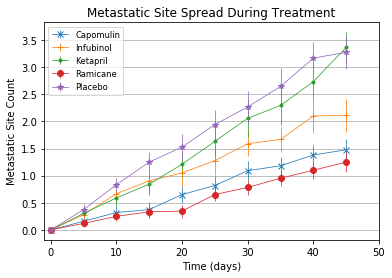

In [9]:
# Store the Mean Met. Site Data Grouped by Drug and Timepoint 
#make the plot
fig, ax = plt.subplots()
x_axis = np.arange(0,50,5)
#loop through the drugs in drug list to procedurally generate plot instead of hardcoding each drug
for i in range(0,len(druglist)):
    ax.errorbar(x_axis, drugdf.iloc[:,1+2*i], yerr = drugdf2.iloc[:,2+2*i], marker = next(marker), ls = '-', lw = 0.75, label = druglist[i])
ax.set_xlim(-1,50)
ax.set_xlabel("Time (days)")
ax.set_ylabel("Metastatic Site Count")
plt.legend(loc="best", fontsize="small", fancybox=True)
plt.title("Metastatic Site Spread During Treatment")
plt.grid(axis = 'y')
plt.show()

In [10]:
#The plot we're trying to replicate:

![Metastatic Spread During Treatment](../Images/spread.png)

## Survival Rates

In [11]:
# Store the Count of Mice Grouped by Drug and Timepoint (W can pass any metric)

drugdf3 = pd.DataFrame([])

for i in range(0,len(druglist)):
    for j in range(0,len(days)):
        
        temp1 = df_orig.loc[(df_orig['Drug'] == druglist[i]) & (df_orig['Timepoint'] == days[j])]
        mousecount = temp1["Mouse ID"].count()
                
        #set up a new dataframe for each new drug
        if j == 0:
            temp2 = pd.DataFrame(columns=["Timepoint",str("Mousepct_" + druglist[i])])
            totalmice = mousecount

        temp2.loc[j] = [days[j],((mousecount/totalmice)*100)]
        
    if i != 0:
        drugdf3 = drugdf3.merge(temp2, on = "Timepoint", how = 'outer')
    elif i == 0:
        drugdf3 = temp2

In [12]:
drugdf3

,Timepoint,Mousepct_Capomulin,Mousepct_Infubinol,Mousepct_Ketapril,Mousepct_Ramicane,Mousepct_Placebo
0,0.0,100.0,100.0,100.0,100.0,100.0
1,5.0,100.0,100.0,92.0,100.0,96.0
2,10.0,100.0,84.0,88.0,96.0,96.0
3,15.0,96.0,84.0,76.0,96.0,80.0
4,20.0,92.0,80.0,76.0,92.0,76.0
5,25.0,88.0,72.0,76.0,92.0,68.0
6,30.0,88.0,68.0,72.0,92.0,60.0
7,35.0,88.0,48.0,68.0,84.0,56.0
8,40.0,84.0,40.0,60.0,80.0,48.0
9,45.0,84.0,36.0,44.0,80.0,44.0


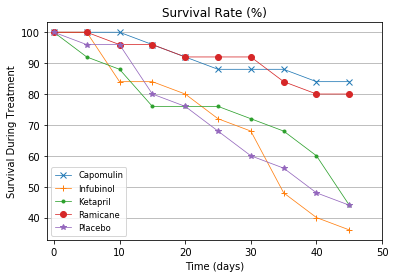

In [13]:
#make the plot
fig, ax = plt.subplots()
x_axis = np.arange(0,50,5)
#loop through the drugs in drug list to procedurally generate plot instead of hardcoding each drug
for i in range(0,len(druglist)):
    ax.plot(x_axis, drugdf3.iloc[:,1+i], marker = next(marker), lw = 0.75, ls = '-', label = druglist[i])
ax.set_xlim(-1,50)
ax.set_xlabel("Time (days)")
ax.set_ylabel("Survival During Treatment")
plt.legend(loc="best", fontsize="small", fancybox=True)
plt.title("Survival Rate (%)")
plt.grid(axis = 'y')
plt.show()

In [14]:
#The plot we're trying to replicate:

![Metastatic Spread During Treatment](../Images/survival.png)

## Summary Bar Graph

In [15]:
# Calculate the percent changes in tumor volume for each drug

In [16]:
#copy and paste the process from above :)
#make an empty dataframe
drugdf4 = pd.DataFrame([])
v1 = 0
v2 = 0
#loop through drugs, loop through days
for i in range(0,len(druglist)):
    for j in range(0,len(days)):
        #get the data
        temp1 = df_orig.loc[(df_orig['Drug'] == druglist[i]) & (df_orig['Timepoint'] == days[j])]
        TV = temp1["Tumor Volume (mm3)"].mean()
                
        #set up a new dataframe for each new drug, grab the starting and ending tumor volume
        if j == 0:
            temp2 = pd.DataFrame(columns=["Timepoint",str("TVPctChange_" + druglist[i])])
            v1 = TV
        if j == len(days)-1:
            v2 = TV
    
        temp2.loc[0] = [days[j],((v2/v1)*100)-100]
        
    if i != 0:
        drugdf4 = drugdf4.merge(temp2, on = "Timepoint", how = 'outer')
    elif i == 0:
        drugdf4 = temp2

drugdf4.drop(columns=["Timepoint"],inplace = True)
drugdf4

,TVPctChange_Capomulin,TVPctChange_Infubinol,TVPctChange_Ketapril,TVPctChange_Ramicane,TVPctChange_Placebo
0,-19.475303,46.123472,57.028795,-22.3209,51.29796


In [17]:
#had trouble formatting when pandaplotting bar chart straight from drugdf4 with 1 val per column
#we'll try the simple approach and just get a list of values out
pctlist = []
for i in range(0,len(druglist)):
    pctlist.append(drugdf4[str("TVPctChange_" + druglist[i])].sum())
pctlist

[-19.47530266789417,
 46.123471727851864,
 57.02879468660606,
 -22.32090046276666,
 51.29796048315151]

In [18]:
#make a function that formats values for % change in tumor growth red if >0, else green
def formatter(val1):
    if val1 > 0:
        return "red"
    return "green"
#make a function that rotates text to improve bar chart formatting based on total number of drugs being plotted
def rohtaht(val2):
    if val2 > 5:
        return "vertical"
    return "horizontal"

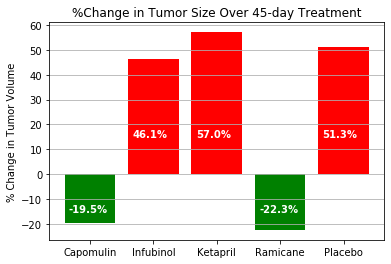

In [19]:
#make the plot
#the example plot is formatted poorly because the tick locations aren't centered on each drug.
#the white space plus the centered tick marks make mine a little easier to read
x_axis = np.arange(0,len(druglist))
tick_locations = [value for value in x_axis]
for i in range(0,len(druglist)):
    plt.bar(i,pctlist[i],color = formatter(pctlist[i]))
    plt.text(i-0.33,np.sign(pctlist[i])*15,
             str("{:.1f}%".format(pctlist[i])),
             color = 'white',
             rotation = rohtaht(len(druglist)),
             fontweight = 'bold')
plt.xticks(tick_locations, druglist, rotation = rohtaht(len(druglist)))
plt.title("%Change in Tumor Size Over 45-day Treatment")
plt.ylabel("% Change in Tumor Volume")
plt.grid(axis = 'y')
plt.show()

![Metastatic Spread During Treatment](../Images/change.png)

# Analysis / Conclusions

In [20]:
#Ramicane was not one of the 4 drugs the assignment originally asked us to analyze, however I elected to include it because--
# it performed better than most of the other drugs that were included.

#Ramicane and Capomulin both appear to be potentially viable treatments and were approximately equally effective.
    #Ramicane was slightly better at reducing the % change in tumor volume and metastatic site count (significance level not calculated).
    #Capomulin had a slightly higher survivability compared with Ramicane as measured at the conclusion of the test (significance level not calculated).

#Some drugs actually had a survival percentage worse than the placebo--
#either a function of limited sample size or a confounding variable or harmful drug effect. I'm looking at you Propriva!

#Ketapril performed no better than the placebo in terms of effect on tumor volume (absolute size or percent change).

#how did all of the mice magically start out with tumors of exactly 45 mm^3 ? Very suspicious. Probably too much BPA in their tiny mouse water bottles...


